In [29]:
# Import required libraries for this project.
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from skmultilearn.adapt import MLkNN

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint  

from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shais\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# Load data into pandas dataframes.
TRAIN_DATA_PATH = '../data/train.csv'
TEST_DATA_PATH = '../data/test.csv'
TEST_LABELS_PATH = '../data/test_labels.csv'

df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)
df_test_labels = pd.read_csv(TEST_LABELS_PATH)

In [42]:
# Printing first 5 rows of training data.
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [43]:
# Getting all the ids having label value as -1 and removing them from the test data.
ids_to_remove = (df_test_labels[df_test_labels.toxic == -1]).id
df_test = df_test[~df_test['id'].isin(ids_to_remove)]
df_test_labels = df_test_labels[~df_test_labels['id'].isin(ids_to_remove)]

In [44]:
df_test.head()

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [45]:
df_test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0


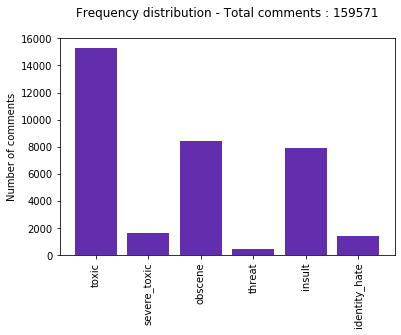

In [46]:
# Plotting a frequency distribution graph.

total = len(df_train)
toxic_count = (df_train.toxic.values == 1).sum()
severe_toxic_count = (df_train.severe_toxic.values == 1).sum()
obscene_count = (df_train.obscene.values == 1).sum()
threat_count = (df_train.threat.values == 1).sum()
insult_count = (df_train.insult.values == 1).sum()
identity_hate_count = (df_train.identity_hate.values == 1).sum()

comment_classes = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')
y_pos = np.arange(len(comment_classes))

plt.title(f'Frequency distribution - Total comments : {total}\n')
plt.ylabel('Number of comments') 

freq = [toxic_count,severe_toxic_count,obscene_count,threat_count,insult_count,identity_hate_count]

plt.bar(y_pos, freq, align='center', color='#632EAE')
plt.xticks(y_pos, comment_classes, rotation=90)

plt.grid(False)
plt.show()

In [47]:
# Getting info about the number of comments which are toxic and/or belongs to more than one toxicity level.
c1,c2 = 0,0
temp = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

for tup in temp.itertuples(index=False):
    c = np.count_nonzero(tup)
    if c:
        c1 = c1 + 1
    if c > 1:
        c2 = c2 + 1

print(f'Number of comments which belongs to one of the toxic class : {c1}')
print(f'Number of comments which belongs to more than one toxic classes : {c2}')

Number of comments which belongs to one of the toxic class : 16225
Number of comments which belongs to more than one toxic classes : 9865


Average length of a comment : 394.0732213246768


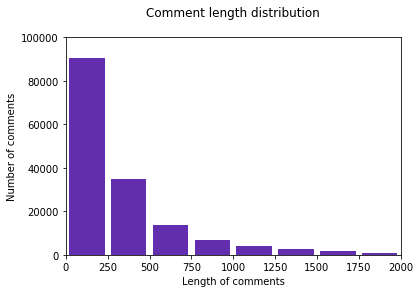

In [48]:
# Plotting a graph of comment length distribution.
comments = df_train.loc[:, 'comment_text']

len_arr = [len(comments[i]) for i in range(comments.shape[0])]

avg_len = sum(len_arr) / len(len_arr)
print(f'Average length of a comment : {avg_len}')

bins = [1,250,500,750,1000,1250,1500,1750,2000]
plt.hist(len_arr, bins=bins, rwidth=0.85, color='#632EAE')

plt.title(f'Comment length distribution\n')
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')

plt.axis([0, 2000, 0, 100000])

plt.grid(False)
plt.show()

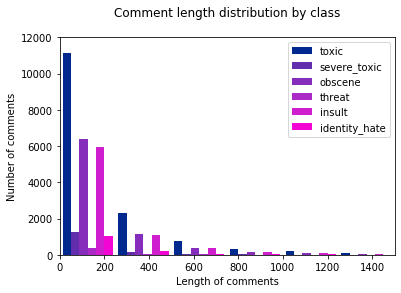

In [49]:
# Plotting a graph of comment length distribution by class.
temp = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
temp = temp.to_numpy()

y = np.zeros(temp.shape)

for i in range(comments.shape[0]):
    cmt_len = len(comments[i])
    # If toxic
    if temp[i][0]:
        y[i][0] = cmt_len
    
    # If severe_toxic
    if temp[i][1]:
        y[i][1] = cmt_len
        
    # If obscene
    if temp[i][2]:
        y[i][2] = cmt_len
    
    # If threat
    if temp[i][3]:
        y[i][3] = cmt_len
        
    # If insult
    if temp[i][4]:
        y[i][4] = cmt_len
        
    # If identity_hate
    if temp[i][5]:
        y[i][5] = cmt_len

bins = [1,250,500,750,1000,1250,1500]
colors = ['#00298F','#632EAE','#872DBB','#AB29C6','#CF1ECE','#F305D3']
plt.hist(y, bins=bins, rwidth=0.9, label=comment_classes, color=colors)

plt.title(f'Comment length distribution by class\n')
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')

plt.legend()

plt.axis([0, 1500, 0, 12000])

plt.grid(False)
plt.show()

In [50]:
# Remove rows having length more than 500.
df_train = df_train[df_train['comment_text'].map(len) <= 500]

In [51]:
# Prepare for special characters removal.
special_chars = string.punctuation.replace('\'','') + "0123456789"
space = "                                         "
trans_table = str.maketrans(special_chars, space)

In [52]:
# Prepare for stop words removal.
stop_words = stopwords.words('english')
stop_words.append('')

for letter in range(ord('b'), ord('z') + 1):
    stop_words.append(chr(letter))

In [53]:
# Prepare for Stemming and Lemmatising
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

In [60]:
# Apply above prepared preprocessors.
comments = df_train.loc[:, 'comment_text'].values

for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trans_table)
    comment = []
    for word in comments[i].split():
        comment.append(stemmer.stem(lemmatiser.lemmatize(word, pos="v")))
    comments[i] = " ".join(comment)

In [ ]:
# Applying count vectorizer using the stop words created.
cv = CountVectorizer(lowercase=False, stop_words=stop_words)

# Convert comments into bag of words format
tf = cv.fit_transform(comments).toarray()

In [ ]:
# Labels
labels = []

temp_labels = df_train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
temp_labels = temp_labels.to_numpy()

for i in range(comments.shape[0]):
    labels.append(temp_labels[i])
    
labels = np.asarray(labels)

In [ ]:
# Splitting the dataset into training and testing.
def shuffle(mat, target, propotion):
    ratio = int(mat.shape[0] / propotion)
    
    X_train = mat[ratio:, :]
    X_test =  mat[:ratio, :]
    
    Y_train = target[ratio:, :]
    Y_test =  target[:ratio, :]
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels, 3)

print(X_train.shape)
print(X_test.shape)

In [ ]:
# Evaluation.
def evaluate(Y_test, predict):
    h_loss = hamming_loss(Y_test, predict)
    acc = accuracy_score(Y_test, predict)
    try:
        l_loss = log_loss(Y_test, predict)
    except:
        l_loss = log_loss(Y_test, predict.toarray())
        
    print("Hamming Loss = {}".format(h_loss*100))
    print("Log Loss = {}".format(l_loss))
    print("Accuracy = {}".format(acc*100))

In [ ]:
# Binary Relevance with Multinomial Naive Bayes.
classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

In [ ]:
# Prediction list.
predictions = classifier.predict(X_test)

In [27]:
# Results for Binary Relevance with Multinomial Naive Bayes.
evaluate(Y_test, predictions)

Hamming Loss = 3.27
Log Loss = 1.92
Accuracy = 88.291235214


In [ ]:
# Binary Relevance with support vector machine classifier.
classifier = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

In [ ]:
# Prediction list.
predictions = classifier.predict(X_test)

In [26]:
# Results for Binary Relevance with support vector machine classifier.
evaluate(Y_test, predictions)

Hamming Loss = 4.26
Log Loss = 0.46
Accuracy = 88.276325974


In [ ]:
# Binary Relevance with Gaussean Naive Bayes.
classifiers = []
for i in range(6):
    classifiers.append(GaussianNB())
    classifiers[i].fit(X_train, Y_train[:, i])

In [ ]:
# Prediction list.
predictions = []
for i in range(6):
    predictions.append(classifiers[i].predict(X_test))
    
predictions = np.asarray(np.transpose(predictions))

In [24]:
# Results for Binary Relevance with Gaussean Naive Bayes.
evaluate(Y_test, predictions)

Hamming Loss = 20.74
Log Loss = 1.422
Accuracy = 52.19


In [ ]:
# Classifier chain with Multinomial Naive Bayes.
classifier = ClassifierChain(MultinomialNB())
classifier.fit(X_train, Y_train)

In [ ]:
# Prediction list.
predictions = classifier.predict(X_test)

In [23]:
# Results for Classifier chain with Multinomial Naive Bayes.
evaluate(Y_test, predictions)

Hamming Loss = 3.56
Log Loss = 1.5
Accuracy = 88.25951231


In [ ]:
# Label Powerset with Multinomial Naive Bayes.
classifier = LabelPowerset(MultinomialNB())
classifier.fit(X_train, Y_train)

In [ ]:
# Prediction list.
predictions = classifier.predict(X_test)

In [21]:
# Results for Label Powerset with Multinomial Naive Bayes.
evaluate(Y_test, predictions)

Hamming Loss = 3.17
Log Loss = 1.47
Accuracy = 88.802365412


In [ ]:
# ML-KNN
classifier = MLkNN(k=2)
classifier.fit(X_train, Y_train)

In [ ]:
# Prediction list.
predictions = classifier.predict(X_test)

In [ ]:
# Results for Label Powerset with Multinomial Naive Bayes.
evaluate(Y_test, predictions)

In [ ]:
# BP-MLL Neural Networks

# Define model architecture
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

In [ ]:
# Compile model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model using ModelCheckpoint.
checkpoint = ModelCheckpoint(filepath='saved_models/weights.best.myneural.h5py', 
                               verbose=1, save_best_only=True)
model.fit(X_train, Y_train, epochs=10, batch_size=32)

In [ ]:
# Prediction list.
predictions = model.predict(X_test)

In [19]:
# Results
l_loss = log_loss(Y_test, predictions)

predictions = np.round(predictions)
h_loss = hamming_loss(Y_test, predictions)

acc = accuracy_score(Y_test, predictions)

print("Hamming Loss = {}".format(h_loss*100))
print("Log Loss = {}".format(l_loss))
print("Accuracy = {}".format(acc*100))

Hamming Loss = 13.96
Log Loss = 0.36
Accuracy = 29.52


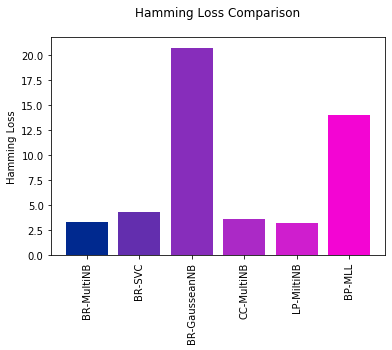

In [12]:
# Hamming Loss Comparison.
models = ['BR-MultiNB', 'BR-SVC', 'BR-GausseanNB', 'CC-MultiNB', 'LP-MiltiNB', 'BP-MLL']
h_loss_arr = [3.27, 4.26, 20.74, 3.56, 3.17, 13.96]

col = ['#00298F','#632EAE','#872DBB','#AB29C6','#CF1ECE','#F305D3']

plt.title(f'Hamming Loss Comparison\n')
plt.ylabel('Hamming Loss')
# plt.xlabel('Models')

plt.xticks(rotation=90)

for i in range(len(h_loss_arr)):
    plt.bar(models[i], h_loss_arr[i], color=col[i])

plt.show()

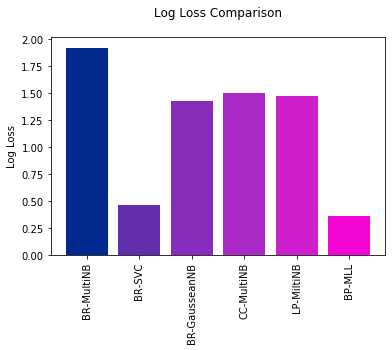

In [13]:
# Log Loss Comparison.
models = ['BR-MultiNB', 'BR-SVC', 'BR-GausseanNB', 'CC-MultiNB', 'LP-MiltiNB', 'BP-MLL']
h_loss_arr = [1.92, 0.46, 1.422, 1.5, 1.47, 0.36]

col = ['#00298F','#632EAE','#872DBB','#AB29C6','#CF1ECE','#F305D3']

plt.title(f'Log Loss Comparison\n')
plt.ylabel('Log Loss')
# plt.xlabel('Models')

plt.xticks(rotation=90)

for i in range(len(h_loss_arr)):
    plt.bar(models[i], h_loss_arr[i], color=col[i])

plt.show()

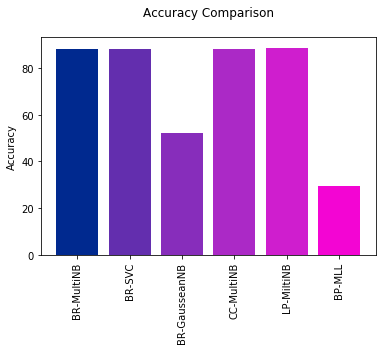

In [15]:
# Accuracy Comparison.
models = ['BR-MultiNB', 'BR-SVC', 'BR-GausseanNB', 'CC-MultiNB', 'LP-MiltiNB', 'BP-MLL']
h_loss_arr = [88.29, 88.27, 52.19, 88.25, 88.80, 29.52]

col = ['#00298F','#632EAE','#872DBB','#AB29C6','#CF1ECE','#F305D3']

plt.title(f'Accuracy Comparison\n')
plt.ylabel('Accuracy')
# plt.xlabel('Models')

plt.xticks(rotation=90)

for i in range(len(h_loss_arr)):
    plt.bar(models[i], h_loss_arr[i], color=col[i])

plt.show()